In [1]:
#!ipcluster start -n 8 --engines=MPI --profile='mpi' # for parallel run: start the engines using terminal
from ipyparallel import Client
rc = Client(profile='mpi')

In [2]:
%%px
# Import the libraries

import numpy as np
import pyfftw as ft 
from mpi4py import MPI
import math
import sys
import os
import pyJHTDB
from pyJHTDB.dbinfo import isotropic1024coarse
from pyJHTDB import libJHTDB
import matplotlib
import matplotlib.pyplot as plt

from FFT3Dfield import FFT3Dfield
from IFFT3Dfield import IFFT3Dfield
from EnergySpectrum import EnergySpectrum

In [3]:
%%px

Nx = isotropic1024coarse['nx']
Ny = isotropic1024coarse['ny']
Nz = isotropic1024coarse['nz']
Lx = isotropic1024coarse['lx']
Ly = isotropic1024coarse['ly']
Lz = isotropic1024coarse['lz']

In [4]:
%%px

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
nproc = comm.Get_size()
if(rank==0):
    print("n_proc = "+str(nproc))
    print("rank = "+str(rank))

[stdout:4] 
n_proc = 8
rank = 0


In [5]:
%%px 
# Computational Domain

nx=Nx//nproc
ny=Ny
nz=Nz
nz_half=nz//2
nek=int(math.sqrt(2.0)/3*Nx)
time = 0.0

chkSz = 32
slabs = nx//chkSz

In [6]:
%%px

cacheEnstrophyData = False
loadEnstrophyFromCache = True

folder = "/home/idies/workspace/scratch"
filename = "enstrophy-isotropic1024coarse-"+str(rank)+"-(t="+str(time)+")"+".npz"
file = folder + "/" + filename

if(loadEnstrophyFromCache):
    comm.Barrier(); t1=MPI.Wtime()
    content = np.load(file)
    
    w2 = ft.zeros_aligned((nx,ny,nz), dtype='float32')
    
    if(int(content['nproc'])!=nproc):
        print("Unmatched number of processes. Must first pre-process to adequate number of process")
    w2[:,:,:] = content['w2']
    
    comm.Barrier(); t2=MPI.Wtime()
    if(rank==0):
        print("Finished loading")
        sys.stdout.write('Load from disk: {0:.2f} seconds\n'.format(t2-t1))

if(cacheEnstrophyData):
    
    comm.Barrier(); t1=MPI.Wtime()
    np.savez(file,w2=w2,nproc=nproc)
    comm.Barrier(); t2=MPI.Wtime()
    if(rank==0):
        sys.stdout.write('Caching the data: {0:.2f} seconds\n'.format(t2-t1))

[stdout:4] 
Finished loading
Load from disk: 11.23 seconds


In [7]:
%%px
comm.Barrier(); t1=MPI.Wtime()

sigma2_w = np.average(w2)

comm.Barrier(); t2=MPI.Wtime()
if(rank==0):
    sys.stdout.write('Calculate average enstrophy: {0:.2f} seconds\n'.format(t2-t1))

comm.Barrier()
sw2 = []
if(rank==0):
    sw2.append(sigma2_w)
    for j in range(1,nproc):
        sigma2_r = comm.recv(source=j,tag=11)
        sw2.append(sigma2_r)
else:
    comm.send(sigma2_w,dest=0,tag=11)
    
comm.Barrier()
sigma2g = 0
if(rank==0):
    print(sw2)
    sigma2 = np.average(np.array(sw2))
    #print(sigma2)
    sigma2g = sigma2#**0.5
    print(r'Average enstrophy = $\langle \omega^2 \rangle$ = '+str(sigma2g))
    for j in range(1,nproc):
        comm.send(sigma2g,dest=j,tag=11)
else:
    sigma2g = comm.recv(source=0,tag=11)
    
comm.Barrier()

[stdout:4] 
Calculate average enstrophy: 0.33 seconds
[406.36386, 373.12411, 322.50809, 310.28839, 367.62122, 339.15225, 402.953, 400.17627]
Average enstrophy = $\langle \omega^2 \rangle$ = 365.273


In [8]:
%%px
comm.Barrier()
minw2 = w2.min()
maxw2 = w2.max()

comm.Barrier()

minwl = []
if(rank==0):
    minwl.append(minw2)
    for j in range(1,nproc):
        minw_r = comm.recv(source=j,tag=11)
        minwl.append(minw_r)
else:
    comm.send(minw2,dest=0,tag=11)

comm.Barrier()

maxwl = []
if(rank==0):
    maxwl.append(maxw2)
    for j in range(1,nproc):
        maxw_r = comm.recv(source=j,tag=11)
        maxwl.append(maxw_r)
else:
    comm.send(maxw2,dest=0,tag=11)

comm.Barrier()

if(rank==0):
    m = min(minwl)
    M = max(maxwl)
    
comm.Barrier()

if(rank==0):
    for j in range(1,nproc):
        comm.send(m,dest=j,tag=22)
else:
    m=comm.recv(source=0,tag=22)
    
comm.Barrier()

if(rank==0):
    for j in range(1,nproc):
        comm.send(M,dest=j,tag=22)
else:
    M=comm.recv(source=0,tag=22)
    
comm.Barrier()

if(rank==0):
    print("minw = "+str(m/sigma2g))
    print("maxw = "+str(M/sigma2g))


[stdout:4] 
minw = 9.42406e-08
maxw = 460.222


In [9]:
%%px
comm.Barrier(); t1=MPI.Wtime()
# Get wavenumber:
myEnergySpc=EnergySpectrum()
kx,ky,kz=myEnergySpc.FindWavenumber(nx,ny,nz,rank)
k2=np.zeros((nx,ny,nz_half+1), dtype='float32')
np.copyto(k2,kx*kx+ky*ky+kz*kz)
k2[0,0,0]=1e-6

comm.Barrier(); t2=MPI.Wtime()
if(rank==0):
    sys.stdout.write('Calculate all wavenumbers: {0:.2f} seconds\n'.format(t2-t1))

[stdout:4] Calculate all wavenumbers: 10.14 seconds


In [10]:
%%px

chi = ft.zeros_aligned((nx,ny,nz), dtype='float32')

In [11]:
%%px
comm.Barrier(); t1=MPI.Wtime()

chi[:,:,:] = 0
chi[w2 > 10*sigma2_w] = 1

comm.Barrier(); t2=MPI.Wtime()
if(rank==0):
    sys.stdout.write('Thresholded set: {0:.2f} seconds\n'.format(t2-t1))

[stdout:4] Thresholded set: 1.79 seconds


In [12]:
%%px 

comm.Barrier(); t1=MPI.Wtime()
# Get velocity field in Fourier space:
myFFT3Dfield=FFT3Dfield()
cchi=myFFT3Dfield.GetFFT3Dfield(chi,nx,ny,nz,nproc,rank)

comm.Barrier(); t2=MPI.Wtime()
if(rank==0):
    sys.stdout.write('Calculate 3D spatial FFT: {0:.2f} seconds\n'.format(t2-t1))

[stdout:4] Calculate 3D spatial FFT: 26.89 seconds


In [13]:
%%px
comm.Barrier(); t1=MPI.Wtime()

tmp = np.absolute(cchi)**2 #(cchi*cchi.conj()).real
ekbins=np.linspace(0.5,nek+0.5,nek+1)
k2rt=np.sqrt(k2)

chi2loc,kedges=np.histogram(k2rt,range=(0.5,nek+0.5),bins=ekbins,weights=tmp)

del k2rt
del tmp

chi2loc=np.float32(chi2loc)
chi2sum=np.zeros(nek,dtype='float32')

comm.Reduce([chi2loc,MPI.REAL],[chi2sum,MPI.REAL],op=MPI.SUM)

chi2k=np.zeros(nek,dtype='float32')
np.copyto(chi2k,chi2sum)

comm.Barrier(); t2=MPI.Wtime()
if(rank==0):
    sys.stdout.write('Calculate Spherical Integration: {0:.2f} seconds\n'.format(t2-t1))

[stdout:4] Calculate Spherical Integration: 14.20 seconds


[output:4]

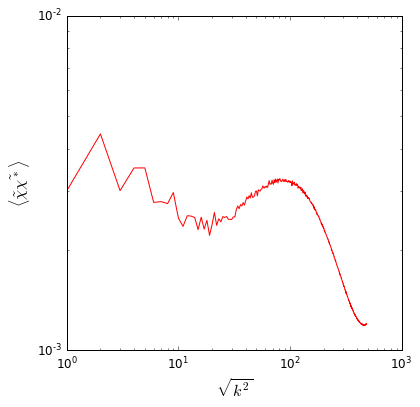

In [15]:
%%px

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

if rank==0:
    norm = np.sum(chi2k)
    SIZE = 12
    ks=np.linspace(1,nek,nek)
    plt.figure(figsize=(6,6))
    #plt.ylim(10**(-3),10**(-2.5))
    plt.xlabel(r'$\sqrt{k^2}$')
    plt.ylabel(r'$\langle\tilde{\chi}\tilde{\chi^*}\rangle$')
    
    plt.loglog(ks,chi2k/norm,'r',label='Unfiltered')
    #plt.loglog(ks,0.065*np.power(ks,-0.62),'k')
    #plt.loglog(ks,0.102*np.power(ks,-0.7),'k')
    
    #plt.xticks([100,200,300,400,500], [r'$10^2$',r'$2 \times 10^2$',r'$3\times 10^2$',r'$4\times 10^2$',r'$5\times 10^2$'])
    #plt.yticks([0.001,0.002,0.003,0.004,0.005], [r'$10^{-3}$',r'$2 \times 10^{-3}$',r'$3\times 10^{-3}$',r'$4\times 10^{-3}$',r'$5\times 10^{-3}$'])

[output:4]

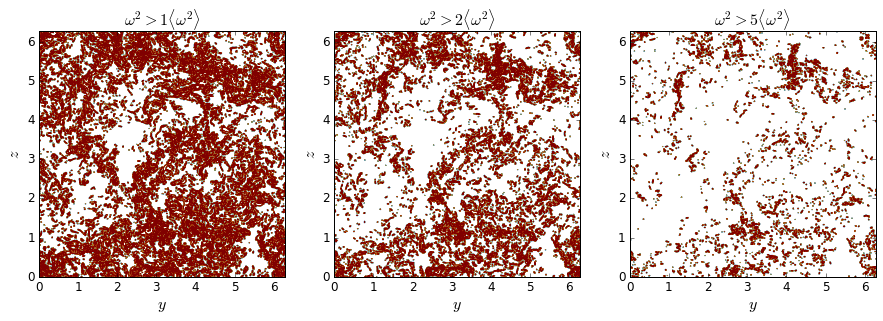

In [16]:
%%px 

if(rank==0):
    plt.figure(figsize=(15,10))
    t = [1,2,5]#,7,10,20]
    for i in range(3):#6):
        chi[:,:,:] = 0
        chi[w2 > t[i]*sigma2_w] = 1
        
        slice0 = chi[0,:,:] 
        
        xlist = np.linspace(0,2*math.pi, Ny)
        ylist = np.linspace(0,2*math.pi, Nz)
        Y, Z = np.meshgrid(xlist, ylist)
        
        ax = plt.subplot(2,3,i+1)#plt.subplot(tt) 
        plt.contour(Y, Z, slice0)
        #plt.imshow(slice0)
        ax.set_title(r'$\omega^2>'+str(t[i])+r' \langle \omega^2\rangle $')
                
        plt.xlabel(r'$y$')
        plt.ylabel(r'$z$')
        plt.gca().set_aspect('equal', adjustable='box')
        
    plt.show()

[output:4]

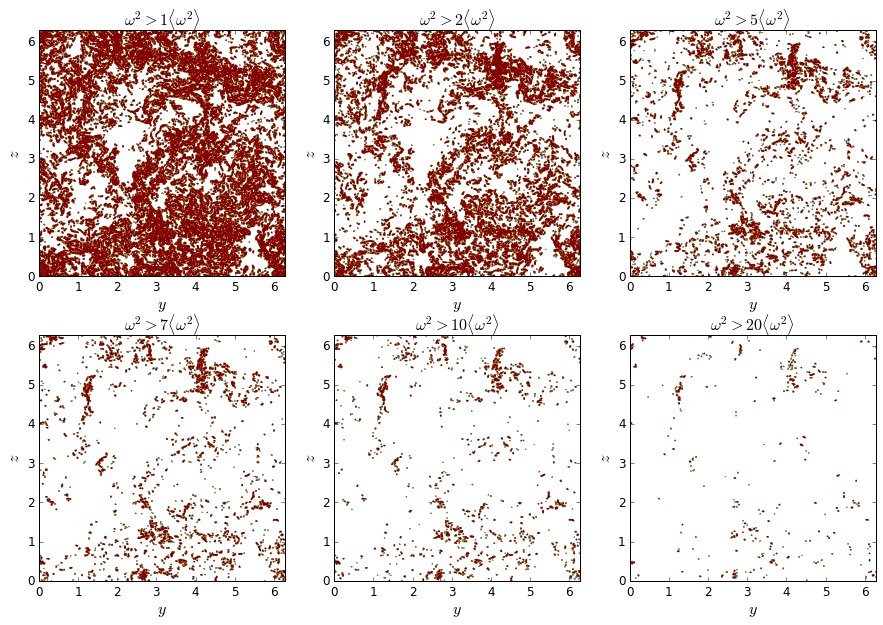

In [17]:
%%px 

if(rank==0):
    plt.figure(figsize=(15,10))
    t = [1,2,5,7,10,20]
    for i in range(6):
        chi[:,:,:] = 0
        chi[w2 > t[i]*sigma2_w] = 1
        
        slice0 = chi[0,:,:] 
        
        xlist = np.linspace(0,2*math.pi, Ny)
        ylist = np.linspace(0,2*math.pi, Nz)
        Y, Z = np.meshgrid(xlist, ylist)
        
        ax = plt.subplot(2,3,i+1)#plt.subplot(tt) 
        plt.contour(Y, Z, slice0)
        #plt.imshow(slice0)
        ax.set_title(r'$\omega^2>'+str(t[i])+r' \langle \omega^2\rangle $')
                
        plt.xlabel(r'$y$')
        plt.ylabel(r'$z$')
        plt.gca().set_aspect('equal', adjustable='box')
        
    plt.show()

In [18]:
%%px

chi[:,:,:] = 0
chi[w2 > 5*sigma2_w] = 1

comm.Barrier();

In [19]:
%%px

comm.Barrier(); t1=MPI.Wtime()

myFFT3Dfield=FFT3Dfield()
cchi=myFFT3Dfield.GetFFT3Dfield(chi,nx,ny,nz,nproc,rank)

comm.Barrier(); t2=MPI.Wtime()

In [20]:
%%px

comm.Barrier(); t1=MPI.Wtime()

tmp = cchi*(cchi.conj())

comm.Barrier(); t2=MPI.Wtime()
if(rank==0):
    sys.stdout.write('Calculate 2-point correlation via Fourier transform: {0:.2f} seconds\n'.format(t2-t1))

[stdout:4] Calculate 2-point correlation via Fourier transform: 3.10 seconds


In [21]:
%%px

miFFT3Dfield=IFFT3Dfield()

tchi=ft.zeros_aligned((nx,ny,nz), dtype='float32')
tcchi=ft.zeros_aligned((nx,ny,nz_half+1), dtype='complex64')

In [22]:
%%px 

comm.Barrier(); t1=MPI.Wtime()

corr=miFFT3Dfield.GetIFFT3Dfield(tmp,nx,ny,nz,nproc,rank)

comm.Barrier(); t2=MPI.Wtime()
if(rank==0):
    sys.stdout.write('Calculate 2-point correlation via Fourier transform: {0:.2f} seconds\n'.format(t2-t1))

[stdout:4] Calculate 2-point correlation via Fourier transform: 27.97 seconds


In [23]:
%%px

X = np.zeros((nx,ny,nz), dtype='float32')
Y = np.zeros((nx,ny,nz), dtype='float32')
Z = np.zeros((nx,ny,nz), dtype='float32')

r2 = np.zeros((nx,ny,nz), dtype='float32')

In [24]:
%%px

for i in range(nx):
    X[i,:,:] = (i+rank*nx)*isotropic1024coarse['dx']# - np.pi

for j in range(ny):
    Y[:,j,:] = j*isotropic1024coarse['dy']# - np.pi
    
for k in range(nz):
    Z[:,:,k] = k*isotropic1024coarse['dz']# - np.pi

In [25]:
%%px

r2[:,:,:] = X[:,:,:]**2+Y[:,:,:]**2+Z[:,:,:]**2

In [26]:
%%px

iCorr = np.zeros((nx,ny,nz), dtype='float32')

In [27]:
%%px

iCorr[:,:,:] = corr[:,:,:]

iCorr[:,512:1024,:] = 0.
iCorr[:,:,512:1024] = 0.

if(rank>=4):
    iCorr[:,:,:] = 0.

In [28]:
%%px 
dx = isotropic1024coarse['dx']
ner = int(1024*np.sqrt(3))
rbins = np.linspace(-0.5*dx,2*np.pi*np.sqrt(3)+0.5*dx,ner+1)

r2rt = np.sqrt(r2)

In [29]:
%%px

comm.Barrier()

corrLoc,redges = np.histogram(r2rt,range=(0.5*dx,(ner+0.5)*dx),bins = rbins,weights=iCorr)

comm.Barrier()

In [30]:
%%px

corrLoc=np.float32(corrLoc)
corrSum=np.zeros(ner,dtype='float32')
corrF=np.zeros(ner,dtype='float32')


In [31]:
%%px 

comm.Barrier(); t1=MPI.Wtime()

comm.Reduce([corrLoc,MPI.REAL],[corrSum,MPI.REAL],op=MPI.SUM)

np.copyto(corrF,corrSum)

comm.Barrier(); t2=MPI.Wtime()

[output:4]

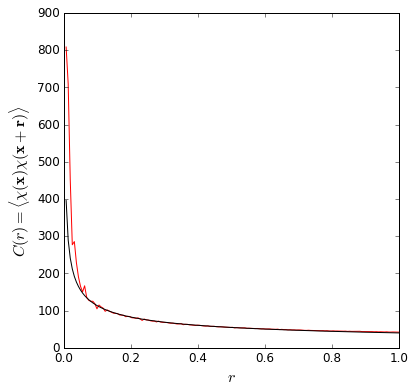

In [42]:
%%px

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

if rank==0:
    norm = np.sum(corrF)
    SIZE = 12
    rp=np.linspace(1*dx,ner*dx,ner)
    plt.figure(figsize=(6,6))
    plt.xlabel(r'$r$')
    plt.ylabel(r'$C(r) = \langle \chi({\bf x}) \chi({\bf x}+{\bf r})\rangle$')
    plt.xlim([0,1])
    
    plt.plot(rp,corrF*(rp**(-2)),'r',label='Unfiltered')
    plt.plot(rp,40*np.power(rp,-0.45),'k')

[output:4]

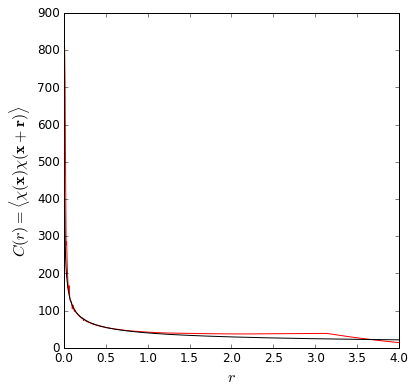

In [41]:
%%px

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

if rank==0:
    norm = np.sum(corrF)
    SIZE = 12
    #ekbins=np.linspace(0.5,nek+0.5,nek+1)
    #ks=np.linspace(1,nek,nek)
    rp=np.linspace(1*dx,ner*dx,ner)
    plt.figure(figsize=(6,6))
    
    plt.xlabel(r'$r$')
    plt.ylabel(r'$C(r) = \langle \chi({\bf x}) \chi({\bf x}+{\bf r})\rangle$')
    #rpt = rp[rp<4.]
    #corrF = corrF[rpt<4.]
    
    #print(corrF.shape)
    #print(rp.shape)
    
    plt.xlim([0,4])
    
    plt.plot(rp,corrF*(rp**(-2)),'r',label='Unfiltered')
    plt.plot(rp,40*np.power(rp,-0.45),'k')

In [1]:
%%px

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

if rank==0:
    norm = np.sum(corrF)
    SIZE = 12
    rp=np.linspace(1*dx,ner*dx,ner)
    plt.figure(figsize=(6,6))
    
    plt.xlabel(r'$r$')
    plt.ylabel(r'$C(r) = \langle \chi({\bf x}) \chi({\bf x}+{\bf r})\rangle$')
    
    plt.xlim([0.01,4])
    plt.ylim([1,1000])
    
    plt.loglog(rp,corrF*(rp**(-2)),'r',label='Unfiltered')
    plt.loglog(rp,40*np.power(rp,-0.45),'k')

ERROR: Cell magic `%%px` not found.


In [105]:
%%px

chi2 = ft.zeros_aligned((nx,ny,nz), dtype='float32')
chi5 = ft.zeros_aligned((nx,ny,nz), dtype='float32')

In [125]:
%%px

chi5[:,:,:] = 0
chi5[w2 > 5*sigma2_w] = 1

chi2[:,:,:] = 0
chi2[w2 > 2*sigma2_w] = 1

comm.Barrier(); 

In [126]:
%%px

cchi2=myFFT3Dfield.GetFFT3Dfield(chi2,nx,ny,nz,nproc,rank)
cchi5=myFFT3Dfield.GetFFT3Dfield(chi5,nx,ny,nz,nproc,rank)

comm.Barrier(); 

In [127]:
%%px 

comm.Barrier(); t1=MPI.Wtime()

tmp2 = cchi2**2
corr2[:,:,:]=miFFT3Dfield.GetIFFT3Dfield(tmp2,tchi,tcchi,nx,ny,nz,nproc,rank)

comm.Barrier(); t2=MPI.Wtime()
if(rank==0):
    sys.stdout.write('Calculate 2-point correlation via Fourier transform: {0:.2f} seconds\n'.format(t2-t1))

[stdout:4] Calculate 2-point correlation via Fourier transform: 28.16 seconds


In [128]:
%%px 

comm.Barrier(); t1=MPI.Wtime()

tmp5 = cchi5**2
corr5[:,:,:]=miFFT3Dfield.GetIFFT3Dfield(tmp5,tchi,tcchi,nx,ny,nz,nproc,rank)

comm.Barrier(); t2=MPI.Wtime()
if(rank==0):
    sys.stdout.write('Calculate 2-point correlation via Fourier transform: {0:.2f} seconds\n'.format(t2-t1))

[stdout:4] Calculate 2-point correlation via Fourier transform: 24.77 seconds


In [132]:
%%px

print(corr2[corr2==corr5].shape)

[stdout:0] (134217728,)
[stdout:1] (134217728,)
[stdout:2] (134217728,)
[stdout:3] (134217728,)
[stdout:4] (134217728,)
[stdout:5] (134217728,)
[stdout:6] (134217728,)
[stdout:7] (134217728,)


In [75]:
%%px

comm.Barrier(); t1=MPI.Wtime()

corrLoc2,redges2 = np.histogram(r2rt,range=(0.5*dx,(ner+0.5)*dx),bins = rbins,weights=corr)
corrLoc5,redges5 = np.histogram(r2rt,range=(0.5*dx,(ner+0.5)*dx),bins = rbins,weights=corr)

comm.Barrier(); t2=MPI.Wtime()
if(rank==0):
    sys.stdout.write('Radial integration: {0:.2f} seconds\n'.format(t2-t1))

[stdout:7] Radial integration: 37.88 seconds


In [77]:
%%px

corrLoc2=np.float32(corrLoc)
corrSum2=np.zeros(ner,dtype='float32')

corrLoc5=np.float32(corrLoc)
corrSum5=np.zeros(ner,dtype='float32')

corrF2=np.zeros(ner,dtype='float32')
corrF5=np.zeros(ner,dtype='float32')

In [78]:
%%px

comm.Barrier(); t1=MPI.Wtime()

comm.Reduce([corrLoc2,MPI.REAL],[corrSum2,MPI.REAL],op=MPI.SUM)
np.copyto(corrF2,corrSum2)

comm.Reduce([corrLoc5,MPI.REAL],[corrSum5,MPI.REAL],op=MPI.SUM)
np.copyto(corrF5,corrSum5)

comm.Barrier(); t2=MPI.Wtime()

[output:7]

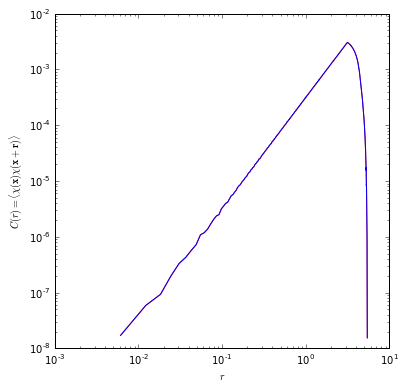

In [80]:
%%px

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

if rank==0:
    norm = np.sum(corrF)
    SIZE = 12
    #ekbins=np.linspace(0.5,nek+0.5,nek+1)
    #ks=np.linspace(1,nek,nek)
    rp=np.linspace(1*dx,ner*dx,ner)
    plt.figure(figsize=(6,6))
    
    plt.xlabel(r'$r$')
    plt.ylabel(r'$C(r) = \langle \chi({\bf x}) \chi({\bf x}+{\bf r})\rangle$')
    
    plt.loglog(rp,corrF2/norm,'r',label='Unfiltered')
    plt.loglog(rp,corrF5/norm,'b',label='Unfiltered')